In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 1*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-01-30 11:42:36.006642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 11:42:36.247766: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-30 11:42:36.922594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-01-30 11:42:43.728773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 11:42:44.461677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [2]:
@tf.function
def derivatives(pinn, x):
    y = pinn.net(x)
    p1, p2 = pinn.gradients(x, y)
    return y, p1, p2

# Two-dimensional data

In [3]:
class Derivatives_2d_single_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("df/dx", "df/dy"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]        
        df_dx = r[:,0:1]
        df_dy = r[:,1:2]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        df_dy_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        print(df_dx.shape)
        print(df_dy.shape)
        print(df_dx_obs.shape)
        print(df_dy_obs.shape)
        return (df_dx - df_dx_obs, df_dy - df_dy_obs)

class Derivatives_2d_double_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=4,
            residual_ret_names=("df/dx", "df/dy", "d2f/dx2", "d2f/dy2"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]
        df_dx = r[:,0:1]
        df_dy = r[:,1:2]
        r2 = tf.gradients(r, inputs)[0]
        d2f_dx2 = r2[:,0:1]
        d2f_dy2 = r2[:,1:2]
        df_dx_obs = x[:, self.input_dim : self.input_dim + 1]
        df_dy_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        d2f_dx2_obs = x[:, self.input_dim+2 : self.input_dim + 3]
        d2f_dy2_obs = x[:, self.input_dim+3 : self.input_dim + 4]
        
        print(df_dx.shape)
        print(df_dy.shape)
        print(d2f_dx2.shape)
        print(d2f_dy2.shape)
        print(df_dx_obs.shape)
        print(df_dy_obs.shape)
        print(d2f_dx2_obs.shape)
        print(d2f_dy2_obs.shape)

        return (df_dx - df_dx_obs,
                df_dy - df_dy_obs,
                d2f_dx2-d2f_dx2_obs,
                d2f_dy2-d2f_dy2_obs)

class Derivatives_2d_second_der_Loss(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=2,
            residual_ret_names=("d2f/dx2", "d2f/dy2"),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]
        r2 = tf.gradients(r, inputs)[0]
        d2f_dx2 = r2[:,0:1]
        d2f_dy2 = r2[:,1:2]
        d2f_dx2_obs = x[:, self.input_dim : self.input_dim + 1]
        d2f_dy2_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        
        #print(df_dx.shape)
        #print(df_dy.shape)
        #print(d2f_dx2.shape)
        #print(d2f_dy2.shape)
        #print(df_dx_obs.shape)
        #print(df_dy_obs.shape)
        #print(d2f_dx2_obs.shape)
        #print(d2f_dy2_obs.shape)

        return (d2f_dx2-d2f_dx2_obs,
                d2f_dy2-d2f_dy2_obs
               )

class Derivatives_2d_second_der_Loss_2(tu.Loss):
    def __init__(
        self,
        dtype,
        loss_grad_type=Loss_Grad_Type.PINN,
        regularise=True,
        input_dim: int = 2,
        print_precision=".5f",
        **kwargs,
    ):
        super().__init__(
            name="Derivatives_Loss",
            loss_grad_type=loss_grad_type,
            regularise=regularise,
            residual_ret_num=1,
            residual_ret_names=("d2f/dx2",),
            print_precision=print_precision,
            **kwargs,
        )
        self.input_dim = input_dim

    @tf.function
    def residual(self, pinn, x):
        inputs = x[:, : self.input_dim]
        outputs = pinn.net(inputs)
        r = tf.gradients(outputs, inputs)[0]
        r2 = tf.gradients(r, inputs)[0]
        d2f_dx2 = r2[:,0:1]
        #d2f_dy2 = r2[:,1:2]
        d2f_dx2_obs = x[:, self.input_dim : self.input_dim + 1]
        #d2f_dy2_obs = x[:, self.input_dim+1 : self.input_dim + 2]
        
        #print(df_dx.shape)
        #print(df_dy.shape)
        #print(d2f_dx2.shape)
        #print(d2f_dy2.shape)
        #print(df_dx_obs.shape)
        #print(df_dy_obs.shape)
        #print(d2f_dx2_obs.shape)
        #print(d2f_dy2_obs.shape)

        return (d2f_dx2-d2f_dx2_obs,
                #d2f_dy2-d2f_dy2_obs
               )

In [21]:
def RMSE(pred, actual, sqrt=True):
    if sqrt:
        return np.sqrt(np.mean((pred-actual)**2))
    else:
        return np.mean((pred-actual)**2)

In [4]:
def to_2d(x):
    return x.reshape((data_2d_x.shape[0], data_2d_x.shape[0]))

In [5]:
def Gaussian_2d(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return np.exp(-(x-locx)**2/(2*scalex**2)-(y-locy)**2/(2*scaley**2))

def Gaussian_2d_df_dx(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(x-locx)/(scalex**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_df_dy(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return (-(y-locy)/(scaley**2))*Gaussian_2d(x, y, locx, locy, scalex, scaley)

def Gaussian_2d_d2f_dx2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scalex**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley)
            -((x-locx)/(scalex**2))*Gaussian_2d_df_dx(x, y, locx, locy, scalex, scaley))

def Gaussian_2d_d2f_dy2(x, y, locx=0.0, locy=0.0, scalex=1.0, scaley=1.0):
    return ((-1.0/scaley**2)*Gaussian_2d(x, y, locx, locy, scalex, scaley) 
            -((y-locy)/(scaley**2))*Gaussian_2d_df_dy(x, y, locx, locy, scalex, scaley))


data_2d_x = np.linspace(0, 2, 128)[:,np.newaxis].astype(np.float32)
data_2d_y = np.linspace(-2, 2, 128)[:,np.newaxis].astype(np.float32)
X,Y = np.meshgrid(data_2d_x, data_2d_y,indexing='ij')
data_2d_z_gaussian = Gaussian_2d(X, Y, 1.0, 0.5, .2, .7)
data_input = np.concatenate([X.flatten()[:,np.newaxis],
                             Y.flatten()[:,np.newaxis]], 
                              axis=1)

data_2d_df_dx = Gaussian_2d_df_dx(X, Y, 1.0, 0.5, .2, .7)
data_2d_df_dy = Gaussian_2d_df_dy(X, Y, 1.0, 0.5, .2, .7)

data_2d_d2f_dx2 = Gaussian_2d_d2f_dx2(X, Y, 1.0, 0.5, .2, .7)
data_2d_d2f_dy2 = Gaussian_2d_d2f_dy2(X, Y, 1.0, 0.5, .2, .7)

ds_gaussian_2d_f = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1)
                              )

ds_gaussian_2d = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_df_dx.flatten()[:,np.newaxis],
                                              data_2d_df_dy.flatten()[:,np.newaxis]], axis=1)
                              )

ds_gaussian_2d_all_ders = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_df_dx.flatten()[:,np.newaxis],
                                              data_2d_df_dy.flatten()[:,np.newaxis],
                                              data_2d_d2f_dx2.flatten()[:,np.newaxis],
                                              data_2d_d2f_dy2.flatten()[:,np.newaxis]], axis=1)
                              )

ds_gaussian_2d_second_ders = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_d2f_dx2.flatten()[:,np.newaxis],
                                              data_2d_d2f_dy2.flatten()[:,np.newaxis]], axis=1)
                              )


ds_gaussian_2d_second_ders2 = TINN_Dataset(tf.float32, 
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_z_gaussian.flatten()[:,np.newaxis]], axis=1),
                              np.concatenate([X.flatten()[:,np.newaxis],
                                              Y.flatten()[:,np.newaxis],
                                              data_2d_d2f_dx2.flatten()[:,np.newaxis]], axis=1)
                              )


def plot(X, Y, Z, title=""):
    plt.title(title)
    plt.contourf(X, Y, Z)
    plt.colorbar()


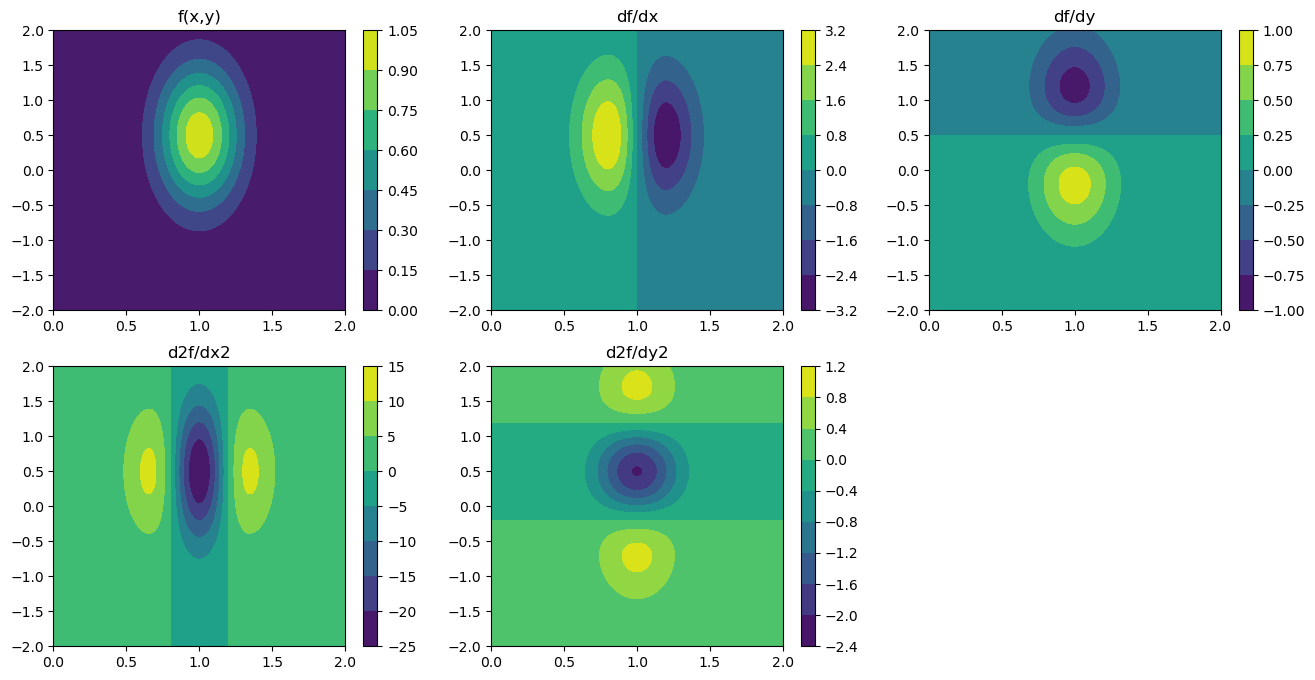

In [6]:
_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, data_2d_z_gaussian, "f(x,y)")
plt.subplot(232)
plot(X, Y, Gaussian_2d_df_dx(X, Y, 1.0, 0.5, .2, .7), "df/dx")
plt.subplot(233)
plot(X, Y, Gaussian_2d_df_dy(X, Y, 1.0, 0.5, .2, .7), "df/dy")
plt.subplot(234)
plot(X, Y, Gaussian_2d_d2f_dx2(X, Y, 1.0, 0.5, .2, .7), "d2f/dx2")
plt.subplot(235)
plot(X, Y, Gaussian_2d_d2f_dy2(X, Y, 1.0, 0.5, .2, .7), "d2f/dy2")
plt.show()

In [16]:
class NN_polar(tu.NN):
    
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        # Map the (x,y) coordinate to (r, theta)
        H_r = tf.reduce_sum(H*H, axis=1)
        H_theta = tf.math.atan2(H[:,0], H[:,1])
        print(H_r)
        print(H_theta)
        # Put back it again
        H = tf.concat([tf.expand_dims(H_r, axis=1), tf.expand_dims(H_theta, axis=1)], axis=1)
        print(H)
        for W, b in zip(self.Ws, self.bs):
            outputs = tf.add(tf.matmul(H, W), b)
            H = tf.tanh(outputs)

        return outputs

In [17]:
layers2 = [2, 128, 128, 1]
pinn2 = NN_polar(layers2, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

# Initial output of an untrained network

Tensor("Sum:0", shape=(16384,), dtype=float32)
Tensor("Atan2:0", shape=(16384,), dtype=float32)
Tensor("concat:0", shape=(16384, 2), dtype=float32)


2023-01-30 11:54:31.723215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


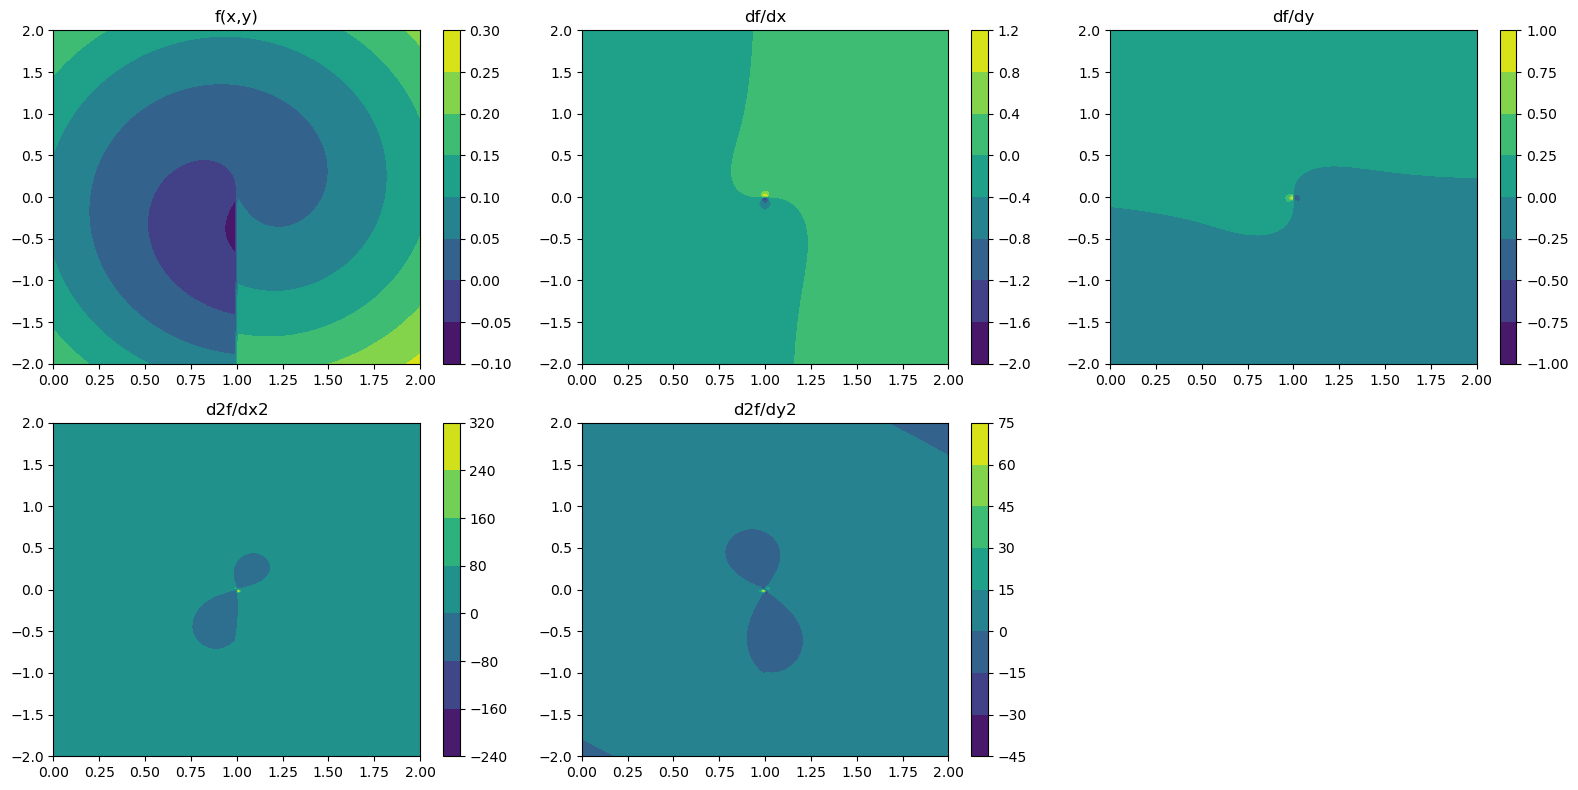

In [18]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), "f(x,y)")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), "df/dx")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), "df/dy")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), "d2f/dx2")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), "d2f/dy2")
plt.tight_layout()
plt.show()

# Train the model

In [19]:
loss2_1 = Observation_Loss(layers2, residual_ret_names=("f(x,y)",))
loss2_2 = Derivatives_2d_single_Loss(pinn2.dtype, print_precision = ".10f")
model2 = tu.TINN(pinn2, [loss2_1, loss2_2], L2(), optimizer=keras.optimizers.Adam(learning_rate=1e-4))
results2 = model2.train(100000+1, 4096, ds_gaussian_2d, print_interval=5000,stop_threshold=1e-6,
                        regularise=False, sample_regularisations=False)


Start of epoch 0
Tensor("Sum:0", shape=(4096,), dtype=float32)
Tensor("Atan2:0", shape=(4096,), dtype=float32)
Tensor("concat:0", shape=(4096, 2), dtype=float32)
(4096, 1)
(4096, 1)
(4096, 1)
(4096, 1)


2023-01-30 11:54:52.064369: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f504800b9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-30 11:54:52.064443: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-01-30 11:54:52.076812: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-30 11:54:52.503578: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


total loss: 3.43815, total regularised loss: 3.43815
Observation_Loss -> 
(1)  f(x,y): 0.05775 
Derivatives_Loss -> 
(2)  df/dx: 0.73408 (3)  df/dy: 0.06771 
Time taken: 11.32s

Start of epoch 5000
total loss: 0.11062, total regularised loss: 0.11062
Observation_Loss -> 
(1)  f(x,y): 0.00068 
Derivatives_Loss -> 
(2)  df/dx: 0.01518 (3)  df/dy: 0.01180 
Time taken: 314.32s

Start of epoch 10000
total loss: 0.01118, total regularised loss: 0.01118
Observation_Loss -> 
(1)  f(x,y): 0.00025 
Derivatives_Loss -> 
(2)  df/dx: 0.00153 (3)  df/dy: 0.00102 
Time taken: 313.06s

Start of epoch 15000
total loss: 0.00699, total regularised loss: 0.00699
Observation_Loss -> 
(1)  f(x,y): 0.00027 
Derivatives_Loss -> 
(2)  df/dx: 0.00098 (3)  df/dy: 0.00051 
Time taken: 311.92s

Start of epoch 20000
total loss: 0.00366, total regularised loss: 0.00366
Observation_Loss -> 
(1)  f(x,y): 0.00010 
Derivatives_Loss -> 
(2)  df/dx: 0.00054 (3)  df/dy: 0.00028 
Time taken: 314.20s

Start of epoch 25000
to

# After training

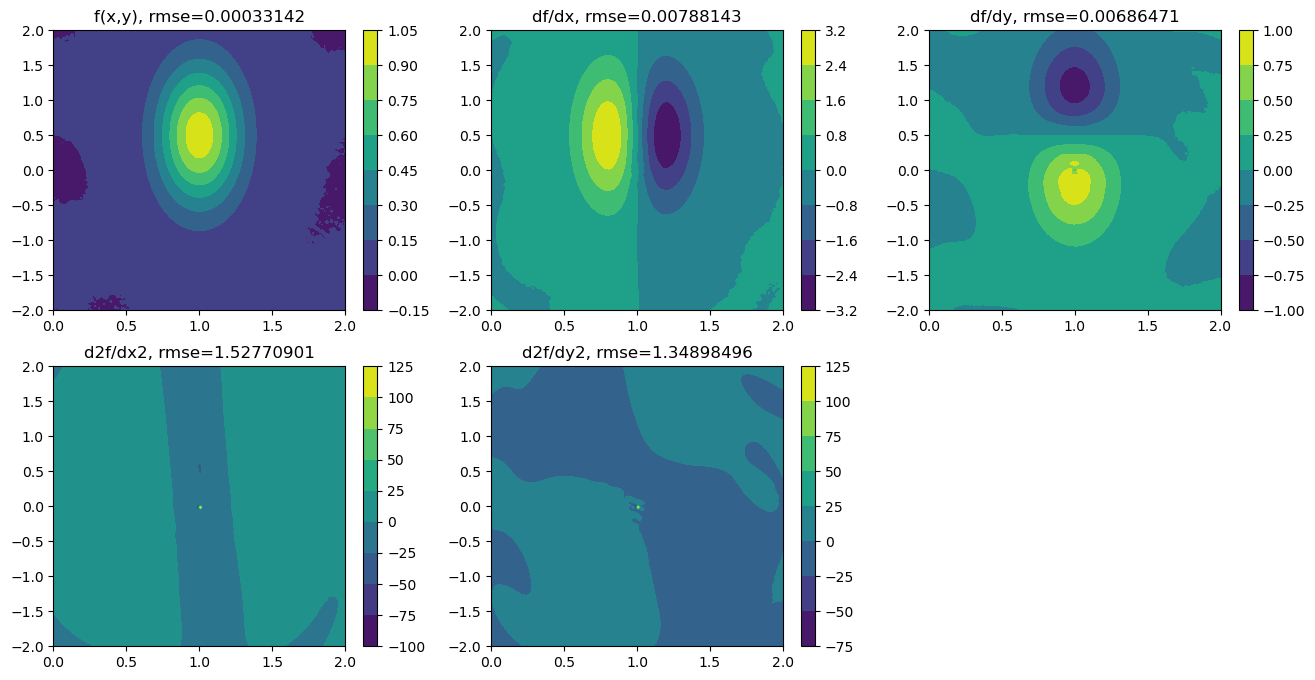

In [22]:
y, y_der_1, y_der_2 = derivatives(pinn2, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.8f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.8f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.8f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.8f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.8f}")
plt.show()

In [24]:
model2.save(".", "model2d_tanh_first_ders")

# Including second derivatives

In [23]:
def RMSE(pred, actual, sqrt=True):
    if sqrt:
        return np.sqrt(np.mean((pred-actual)**2))
    else:
        return np.mean((pred-actual)**2)

In [27]:
layers3 = [2, 128, 128, 1]
pinn3 = tu.NN(layers3, 
             lb= np.amin(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             ub= np.amax(np.concatenate([data_2d_x, data_2d_y], axis=1), 0),
             dtype=tf.float32)

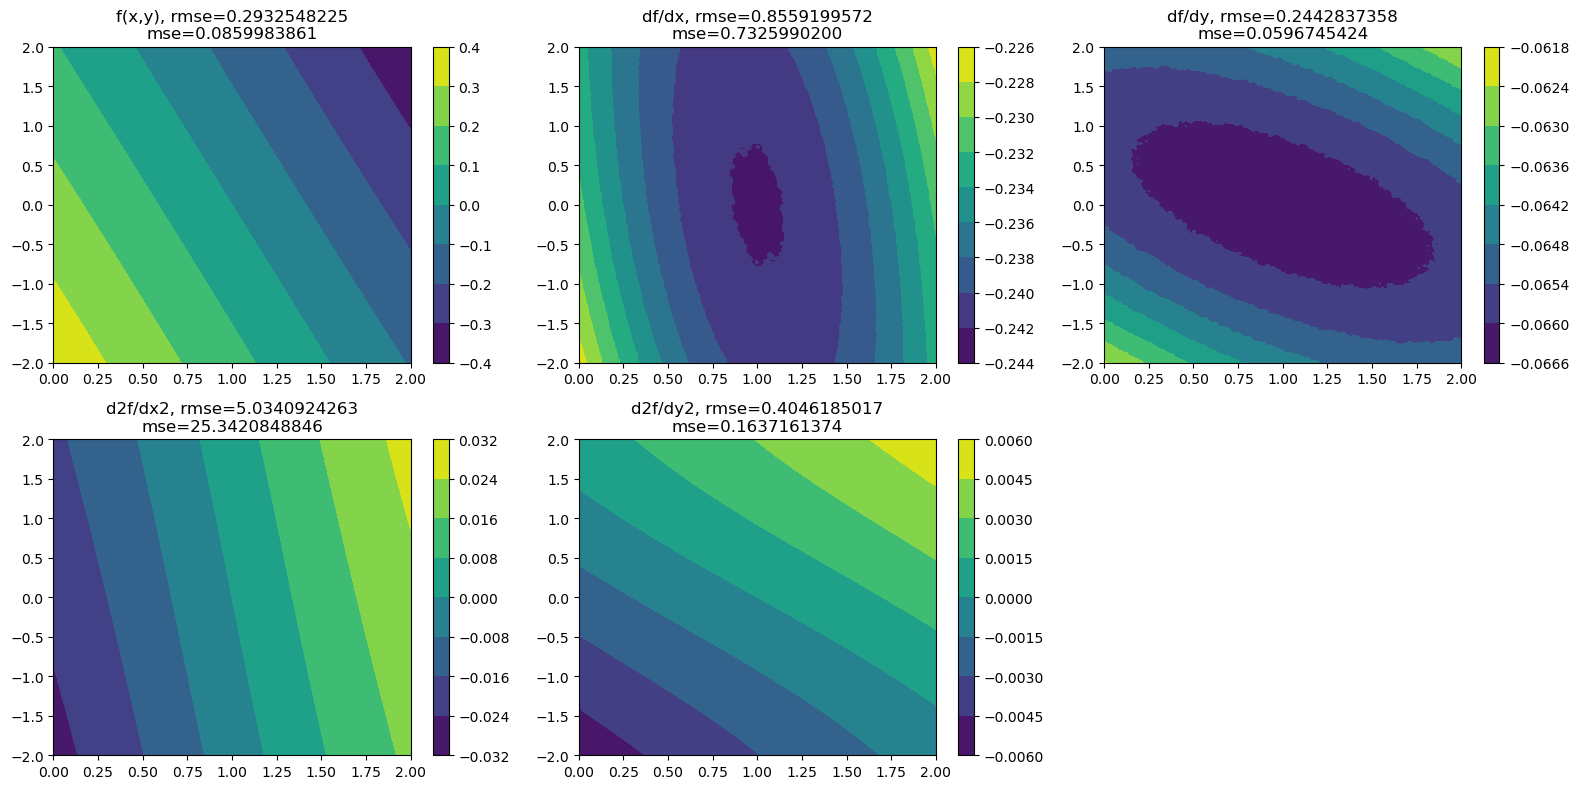

In [28]:
y, y_der_1, y_der_2 = derivatives(pinn3, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [29]:
loss2_1 = Observation_Loss(layers3, residual_ret_names=("f(x,y)",), print_precision = ".10f")
loss2_2 = Derivatives_2d_second_der_Loss(pinn3.dtype, print_precision = ".10f")
model3 = tu.TINN(pinn3, [loss2_1, loss2_2], L2(),
                 optimizer=keras.optimizers.Adam(learning_rate=1e-4), print_precision = ".10f")
results3 = model3.train(10000+1, 4096, ds_gaussian_2d_second_ders, print_interval=500,stop_threshold=1e-6,
                        regularise=False, sample_regularisations=False)


Start of epoch 0
total loss: 102.3553215787, total regularised loss: 102.3553237915
Observation_Loss -> 
(1)  f(x,y): 0.0819824170 
Derivatives_Loss -> 
(2)  d2f/dx2: 25.3431740701 (3)  d2f/dy2: 0.1636745232 
Time taken: 6.92s

Start of epoch 500
total loss: 58.3270290982, total regularised loss: 58.3270339966
Observation_Loss -> 
(1)  f(x,y): 0.0224558535 
Derivatives_Loss -> 
(2)  d2f/dx2: 14.3925116509 (3)  d2f/dy2: 0.1667900846 
Time taken: 31.82s

Start of epoch 1000
total loss: 6.9397463936, total regularised loss: 6.9397463799
Observation_Loss -> 
(1)  f(x,y): 0.0070766468 
Derivatives_Loss -> 
(2)  d2f/dx2: 1.2138560042 (3)  d2f/dy2: 0.5140039753 
Time taken: 31.90s

Start of epoch 1500
total loss: 3.7211174282, total regularised loss: 3.7211174965
Observation_Loss -> 
(1)  f(x,y): 0.0060035583 
Derivatives_Loss -> 
(2)  d2f/dx2: 0.2787397634 (3)  d2f/dy2: 0.6455360437 
Time taken: 31.96s

Start of epoch 2000
total loss: 3.1446179650, total regularised loss: 3.1446177959
Obser

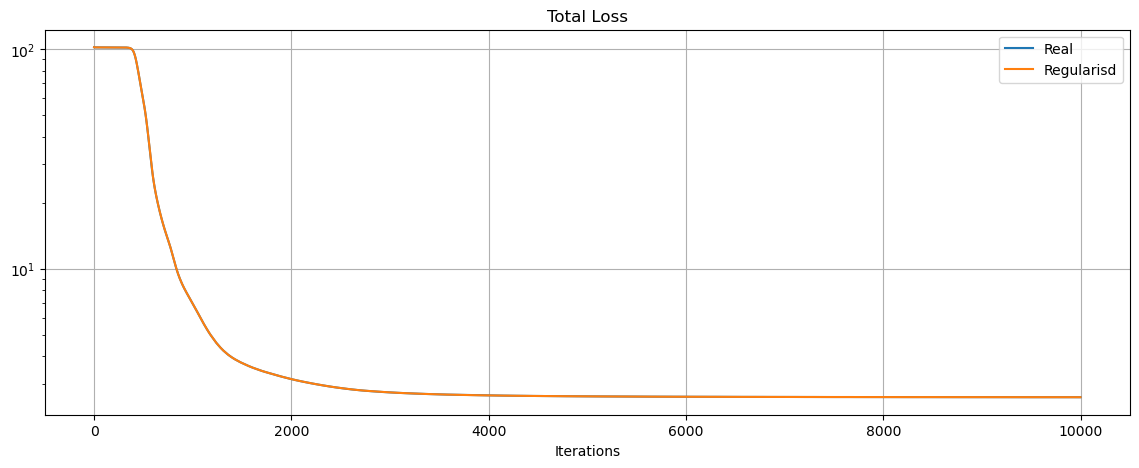

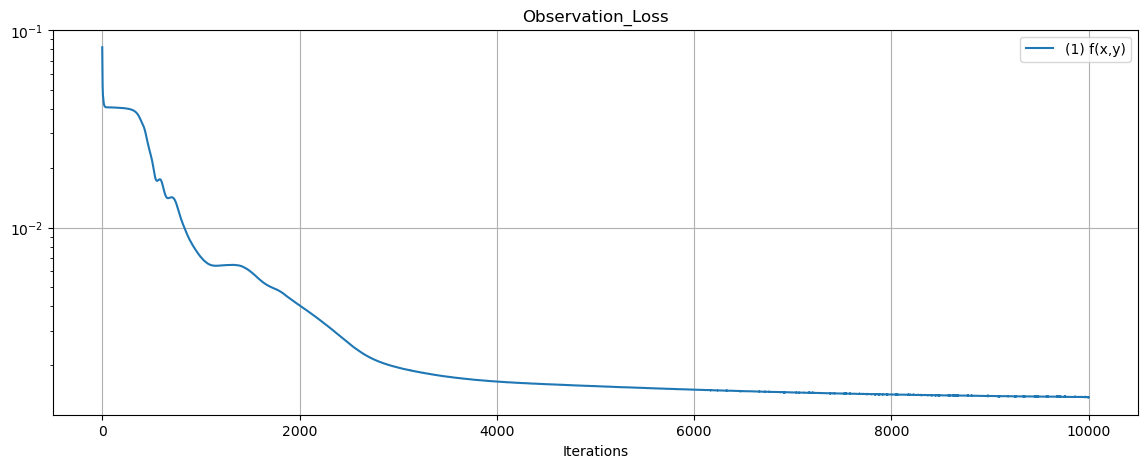

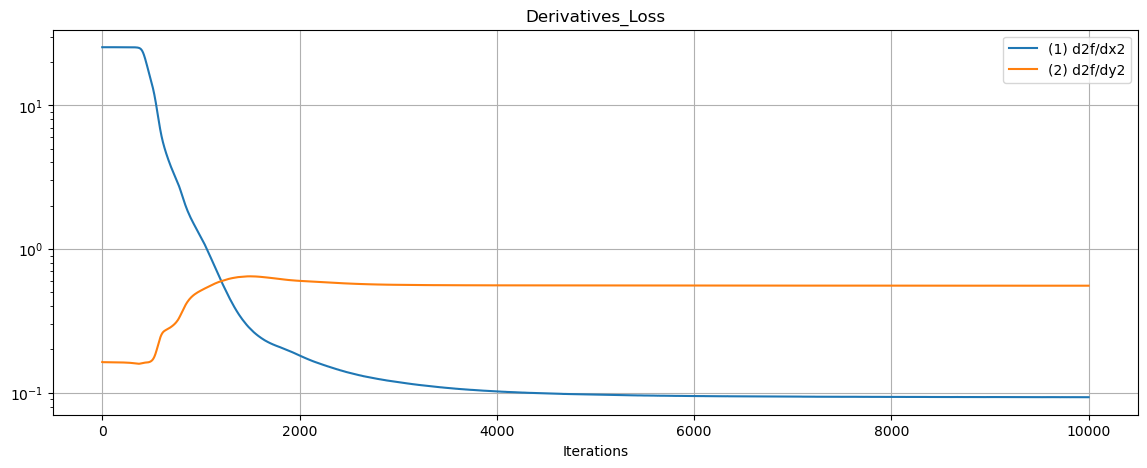

In [30]:
plot_result(merge_dict(results3), model3,start=0)

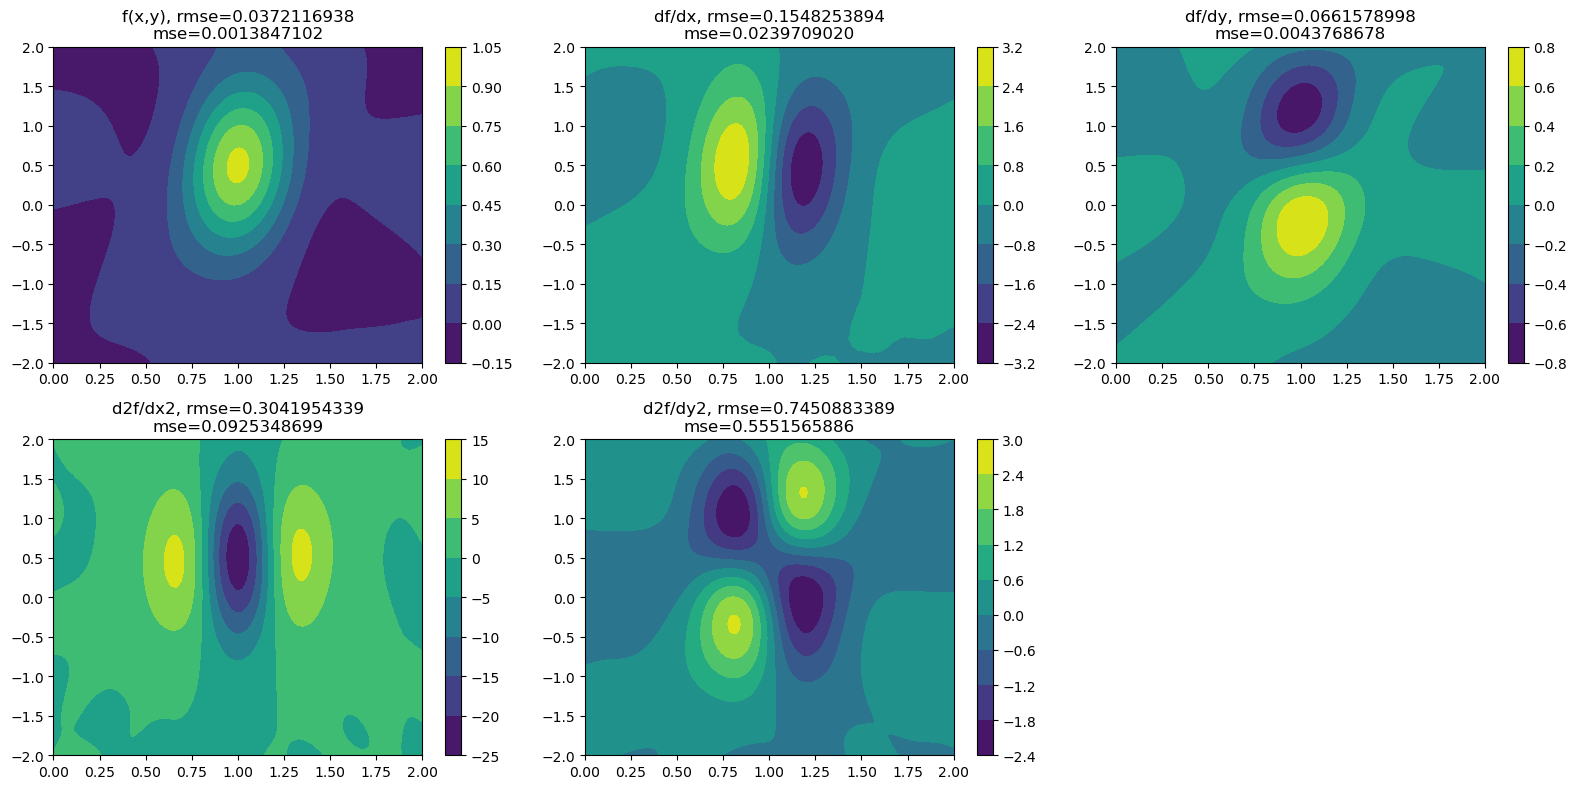

In [32]:
y, y_der_1, y_der_2 = derivatives(pinn3, data_input)


_ = plt.figure(figsize=(16,8))
plt.subplot(231)
plot(X, Y, to_2d(y.numpy()), 
     f"f(x,y), rmse={RMSE(data_2d_z_gaussian, to_2d(y.numpy())):.10f}\n"
     f"mse={RMSE(data_2d_z_gaussian, to_2d(y.numpy()), False):.10f}")
plt.subplot(232)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,0]), 
     f"df/dx, rmse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0])):.10f}\n"
     f"mse={RMSE(data_2d_df_dx, to_2d(y_der_1[0].numpy()[:,0]), False):.10f}")
plt.subplot(233)
plot(X, Y, to_2d(y_der_1[0].numpy()[:,1]), 
     f"df/dy, rmse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1])):.10f}\n"
     f"mse={RMSE(data_2d_df_dy, to_2d(y_der_1[0].numpy()[:,1]),False):.10f}")
plt.subplot(234)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,0]), 
     f"d2f/dx2, rmse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dx2, to_2d(y_der_2[0].numpy()[:,0]),False):.10f}")
plt.subplot(235)
plot(X, Y, to_2d(y_der_2[0].numpy()[:,1]), 
     f"d2f/dy2, rmse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1])):.10f}\n"
    f"mse={RMSE(data_2d_d2f_dy2, to_2d(y_der_2[0].numpy()[:,1]),False):.10f}")
plt.tight_layout()
plt.show()

In [46]:
model2 = tu.TINN.restore(".", "model_tanh_2d_f_x_y_only", ds_gaussian_2d_f)
pinn4 = model2.pinn